In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

def print_warn(*args):
    printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{' '.join(map(str, args))}</font></code>")

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
    results_real_info = yaml.safe_load(results_real_info_file)
df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
    results_gen_info = yaml.safe_load(results_gen_info_file)

df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

results_info = results_gen_info
results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# only consider real localization
df = df[df.localization_node != 'localization_generator']

# df = df[df.amcl_alpha_factor == 1.0]
df = df[df.amcl_alpha_factor.isin([0.0, 0.5, 1.0, 2.0])].copy()

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'std_trajectory_length'] = group_df.trajectory_length.std()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'var_trajectory_length'] = group_df.trajectory_length.var()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'mean_trajectory_length'] = group_df.trajectory_length.mean()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'median_trajectory_length'] = group_df.trajectory_length.median()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
df['norm_trajectory_length_std'] = df.trajectory_length / df.min_trajectory_length / df.std_trajectory_length
df['norm_trajectory_length_mean'] = df.trajectory_length / df.mean_trajectory_length
df['norm_trajectory_length_median'] = df.trajectory_length / df.median_trajectory_length
metrics += ['norm_trajectory_length']
metrics += ['min_trajectory_length']
metrics += ['mean_trajectory_length']
metrics += ['median_trajectory_length']
metrics += ['norm_trajectory_length_std']
metrics += ['norm_trajectory_length_mean']
metrics += ['norm_trajectory_length_median']
metrics_and_versions += ['norm_trajectory_length']
metrics_and_versions += ['mean_trajectory_length']
metrics_and_versions += ['median_trajectory_length']
metrics_and_versions += ['norm_trajectory_length_std']
metrics_and_versions += ['norm_trajectory_length_mean']
metrics_and_versions += ['norm_trajectory_length_median']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if False:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

<ipython-input-5-6ed6609b5e99>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_gen.append(df_real, sort=True)


In [6]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


## Localization performance from system features

### average velocity atan

#### normalized relative translation error

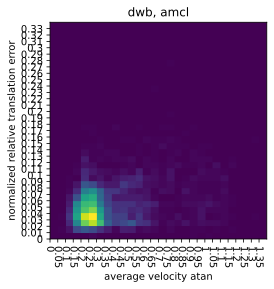

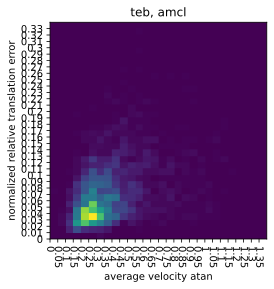

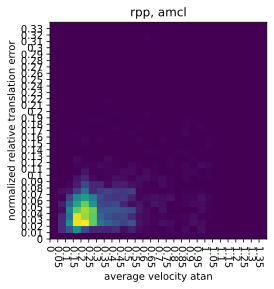

#### normalized relative rotation error

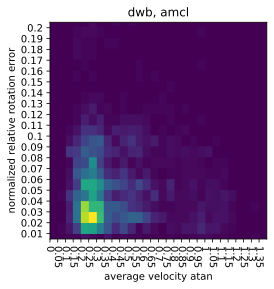

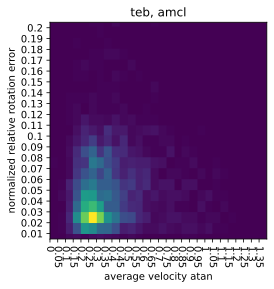

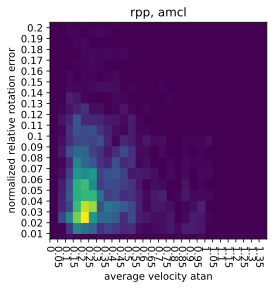

In [8]:
printmd("## Localization performance from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
for x_metric, x_bin_width, x_lim in [
#     [d.average_velocity, 0.01, None], 
#     [d.average_translation_velocity, 0.01, None], 
    [d.average_velocity_atan, 0.05, None],
#     [d.beta_1, None, None],
]:
    printmd(f"### {x_metric.name.replace('_', ' ')}")
    for y_metric, y_bin_width, y_lim in [
#         [d.absolute_translation_error, 0.01, None],
#         [d.absolute_rotation_error, 0.01, None],
        [d.normalized_relative_translation_error, 0.01, None],
        [d.normalized_relative_rotation_error, 0.01, (0, 0.2)],
    ]:
        printmd(f"#### {y_metric.name.replace('_', ' ')}")
        plot_in_out_dist(
            x_metric=x_metric,
            y_metric=y_metric,
            x_bin_width=x_bin_width,
            y_bin_width=y_bin_width,
            selected_df=d,
            x_lim=x_lim,
            y_lim=y_lim,
            out_dir="thesis_plots/localization",
        )


# printmd("## Localization performance from own parameters")

# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0)].copy()
# for x_metric, x_bin_width, x_lim in [
#     [d.amcl_alpha_factor, None, None],
# ]:
#     printmd(f"### {x_metric.name.replace('_', ' ')}")
#     for y_metric, y_bin_width, y_lim in [
#         [d.absolute_translation_error, 0.01, None],
#         [d.absolute_rotation_error, 0.01, None],
#         [d.normalized_relative_translation_error, 0.01, None],
#         [d.normalized_relative_rotation_error, 0.01, (0, 0.2)],
#     ]:
#         printmd(f"#### {y_metric.name.replace('_', ' ')}")
#         plot_in_out_dist(
#             x_metric=x_metric,
#             y_metric=y_metric,
#             x_bin_width=x_bin_width,
#             y_bin_width=y_bin_width,
#             selected_df=d,
#             x_lim=x_lim,
#             y_lim=y_lim,
#             out_dir="thesis_plots/localization",
#         )

In [9]:
# printmd("## avg vel and avg vel atan are similar")

# for x_metric, x_bin_width, x_lim in [
#     [d.average_velocity, 0.01, None], 
#     [d.average_translation_velocity, 0.01, None], 
#     [d.average_rotation_velocity, 0.01, None],
#     [d.average_velocity_atan, 0.05, None],
# ]:
#     printmd(f"### {x_metric.name.replace('_', ' ')}")
#     for y_metric, y_bin_width, y_lim in [
#         [d.average_velocity, 0.01, None], 
#         [d.average_translation_velocity, 0.01, None], 
#         [d.average_rotation_velocity, 0.01, None],
#         [d.average_velocity_atan, 0.05, None],
#     ]:
#         printmd(f"#### {y_metric.name.replace('_', ' ')}")
#         plot_in_out_dist(
#             x_metric=x_metric,
#             y_metric=y_metric,
#             x_bin_width=x_bin_width,
#             y_bin_width=y_bin_width,
#             selected_df=d,
#             x_lim=x_lim,
#             y_lim=y_lim,
#             out_dir="thesis_plots/motion_char_self_correlation",
#         )

### norm trajectory length from localization error

when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length

### normalized relative translation error

#### norm trajectory length

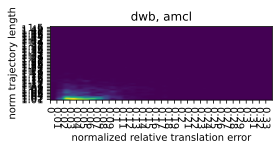

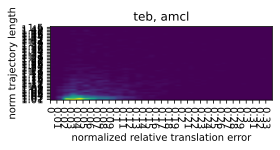

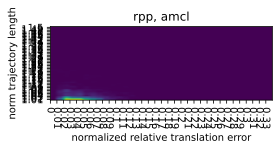

### normalized relative rotation error

#### norm trajectory length

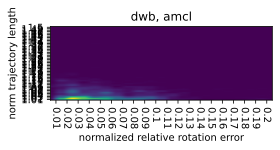

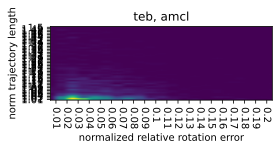

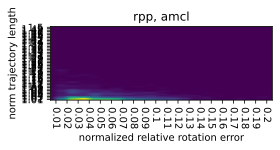

In [10]:

printmd("### norm trajectory length from localization error")
printmd("when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
for x_metric, x_bin_width, x_lim in [
#     [d.absolute_translation_error, 0.01, None],
#     [d.absolute_rotation_error, 0.01, None],
    [d.normalized_relative_translation_error, 0.01, None],
    [d.normalized_relative_rotation_error, 0.01, (0, 0.2)],
]:
    printmd(f"### {x_metric.name.replace('_', ' ')}")
    for y_metric, y_bin_width, y_lim in [
        [d.norm_trajectory_length, 0.01, (1.0, 1.5)],
    ]:
        printmd(f"#### {y_metric.name.replace('_', ' ')}")
        plot_in_out_dist(
            x_metric=x_metric,
            y_metric=y_metric,
            x_bin_width=x_bin_width,
            y_bin_width=y_bin_width,
            selected_df=d,
            x_lim=x_lim,
            y_lim=y_lim,
            out_dir="thesis_plots/local_planner",
        )


## Local Planning performance from robot params, localization params, and environment features

### minimum clearance

#### average velocity atan

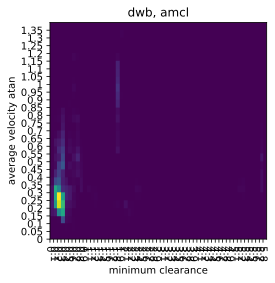

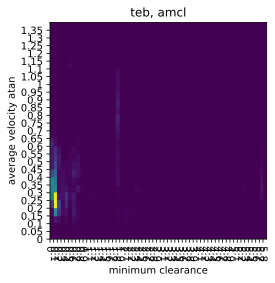

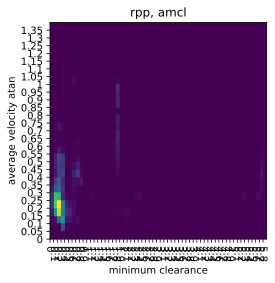

### average clearance

#### average velocity atan

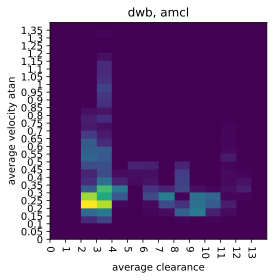

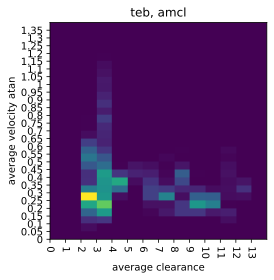

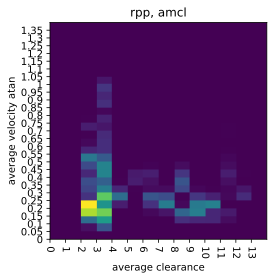

In [11]:

printmd("## Local Planning performance from robot params, localization params, and environment features")

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
for x_metric, x_bin_width, x_lim in [
#     [d.beta_1, None, None],
#     [d.amcl_alpha_factor, None, None],
    [d.minimum_clearance, .1, None],
    [d.average_clearance, 1, None],
]:
    printmd(f"### {x_metric.name.replace('_', ' ')}")
    for y_metric, y_bin_width, y_lim in [
        [d.average_velocity_atan, 0.05, None],
    ]:
        printmd(f"#### {y_metric.name.replace('_', ' ')}")
        plot_in_out_dist(
            x_metric=x_metric,
            y_metric=y_metric,
            x_bin_width=x_bin_width,
            y_bin_width=y_bin_width,
            selected_df=d,
            x_lim=x_lim,
            y_lim=y_lim,
            out_dir="thesis_plots/local_planner",
        )
